In [264]:
import random
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt

In [265]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(42)

In [266]:
ds = load_dataset("cardiffnlp/tweet_eval", "emotion")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

In [267]:
label_names = ds["train"].features["label"].names
NUM_CLASS = len(label_names)

train_ds = ds["train"]
val_ds = ds["validation"]
test_ds = ds["test"]

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
print(NUM_CLASS)
print(label_names)

print(ds["train"].features["label"])
print(len(set(ds["train"]["label"])))


3257
374
1421
4
['anger', 'joy', 'optimism', 'sadness']
ClassLabel(names=['anger', 'joy', 'optimism', 'sadness'])
4


In [268]:
def basic_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9'\s]+", " ", text)
    return text.split()

In [269]:
SPECIALS = ["<pad>", "<unk>"]
PAD, UNK = SPECIALS

min_freq = 2
freq = {}

for ex in train_ds:
    for tok in basic_tokenize(ex["text"]):
        freq[tok] = freq.get(tok, 0) + 1

itos = list(SPECIALS)
for tok, c in freq.items():
    if c >= min_freq:
        itos.append(tok)

stoi = {tok: i for i, tok in enumerate(itos)}
VOCAB_SIZE = len(itos)
print(VOCAB_SIZE)

3714


In [270]:
def numericalize(text):
    tokens = basic_tokenize(text)
    ids = []

    if len(tokens) == 0:
        ids.append(stoi[UNK])
        return ids

    for tok in tokens:
        if tok in stoi:
            ids.append(stoi[tok])
        else:
            ids.append(stoi[UNK])

    return ids

In [271]:
def collate_batch(batch):
    labels = []
    text_list = []
    offsets = [0]

    for ex in batch:
        labels.append(ex["label"])
        ids = numericalize(ex["text"])
        ids_tensor = torch.tensor(ids, dtype=torch.int64)
        text_list.append(ids_tensor)
        offsets.append(ids_tensor.numel())

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text_list)
    labels = torch.tensor(labels, dtype=torch.int64)

    return text, offsets, labels

In [272]:
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

text0, off0, lab0 = next(iter(train_loader))
print(text0.shape)
print(off0.shape)
print(lab0.shape)


torch.Size([1072])
torch.Size([64])
torch.Size([64])


In [273]:
# Note: I used ChatGPT as a supplementary reference for PyTorch syntax and debugging.
class SLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text, offsets):
        x = self.embedding(text, offsets)
        return self.fc(x)

In [274]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_class)

    def forward(self, text, offsets):
        x = self.embedding(text, offsets)
        h = F.relu(self.fc1(x))
        return self.fc2(h)

In [275]:
def run_eval(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for text, offsets, labels in loader:
            outputs = model(text, offsets)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size

            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


In [276]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for text, offsets, labels in loader:
        optimizer.zero_grad()

        outputs = model(text, offsets)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size

        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [277]:
def train_model(model, train_loader, val_loader, test_loader, epochs=25, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_acc": [], "val_acc": [], "test_acc": []}

    for ep in range(1, epochs + 1):
        _, train_acc = train_one_epoch(model, train_loader, optimizer)
        _, val_acc = run_eval(model, val_loader)
        _, test_acc = run_eval(model, test_loader)

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["test_acc"].append(test_acc)

        print(f"Epoch {ep:02d} | train acc {train_acc:.4f} val acc {val_acc:.4f} test acc {test_acc:.4f}")

    return model, history

In [278]:
def plot_test_acc(history, title):
    xs = range(1, len(history["test_acc"]) + 1)
    plt.figure()
    plt.plot(xs, history["test_acc"], marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title(title)
    plt.show()

Epoch 01 | train acc 0.2975 val acc 0.3717 test acc 0.3716
Epoch 02 | train acc 0.4034 val acc 0.4064 test acc 0.4145
Epoch 03 | train acc 0.4375 val acc 0.4171 test acc 0.4194
Epoch 04 | train acc 0.4526 val acc 0.4305 test acc 0.4222
Epoch 05 | train acc 0.4667 val acc 0.4332 test acc 0.4258
Epoch 06 | train acc 0.4777 val acc 0.4439 test acc 0.4342
Epoch 07 | train acc 0.4909 val acc 0.4465 test acc 0.4433
Epoch 08 | train acc 0.5084 val acc 0.4652 test acc 0.4567
Epoch 09 | train acc 0.5269 val acc 0.4759 test acc 0.4673
Epoch 10 | train acc 0.5477 val acc 0.5027 test acc 0.4849
Epoch 11 | train acc 0.5668 val acc 0.5134 test acc 0.4891
Epoch 12 | train acc 0.5880 val acc 0.5160 test acc 0.5067
Epoch 13 | train acc 0.6073 val acc 0.5214 test acc 0.5172
Epoch 14 | train acc 0.6313 val acc 0.5374 test acc 0.5285
Epoch 15 | train acc 0.6481 val acc 0.5455 test acc 0.5376
Epoch 16 | train acc 0.6678 val acc 0.5561 test acc 0.5412
Epoch 17 | train acc 0.6920 val acc 0.5722 test acc 0.55

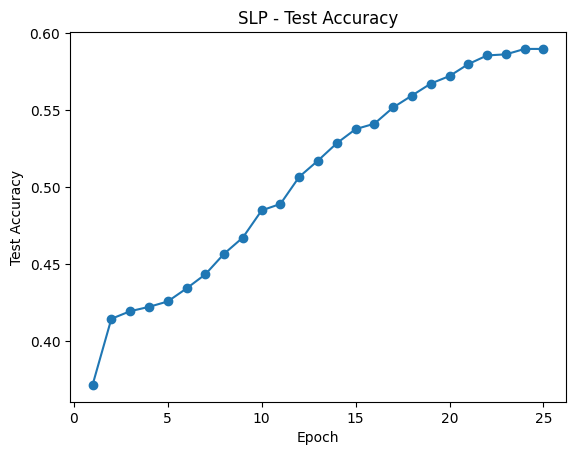

In [279]:
EMBED_DIM = 32
EPOCHS = 25
LR = 1e-3

slp = SLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS)
slp_best, hist_slp = train_model(slp, train_loader, val_loader, test_loader, epochs=EPOCHS, lr=LR)
plot_test_acc(hist_slp, "SLP - Test Accuracy")

Epoch 01 | train acc 0.4237 val acc 0.4278 test acc 0.3927
Epoch 02 | train acc 0.4298 val acc 0.4358 test acc 0.3962
Epoch 03 | train acc 0.4366 val acc 0.4385 test acc 0.4011
Epoch 04 | train acc 0.4590 val acc 0.4572 test acc 0.4265
Epoch 05 | train acc 0.4983 val acc 0.4679 test acc 0.4462
Epoch 06 | train acc 0.5398 val acc 0.4947 test acc 0.4631
Epoch 07 | train acc 0.5729 val acc 0.5107 test acc 0.4954
Epoch 08 | train acc 0.6061 val acc 0.5160 test acc 0.5067
Epoch 09 | train acc 0.6466 val acc 0.5134 test acc 0.5376
Epoch 10 | train acc 0.6795 val acc 0.5348 test acc 0.5384
Epoch 11 | train acc 0.7049 val acc 0.5374 test acc 0.5510
Epoch 12 | train acc 0.7289 val acc 0.5481 test acc 0.5602
Epoch 13 | train acc 0.7501 val acc 0.5561 test acc 0.5658
Epoch 14 | train acc 0.7737 val acc 0.5561 test acc 0.5693
Epoch 15 | train acc 0.7924 val acc 0.5722 test acc 0.5728
Epoch 16 | train acc 0.8084 val acc 0.5695 test acc 0.5785
Epoch 17 | train acc 0.8232 val acc 0.5829 test acc 0.57

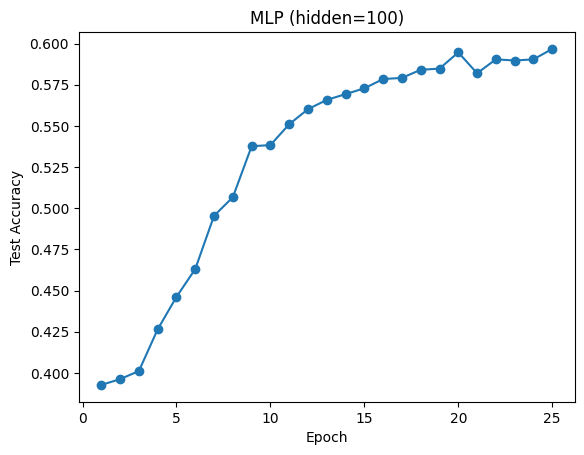

In [280]:
mlp100 = MLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, hidden_dim=100)
mlp100_best, hist_mlp100 = train_model(mlp100, train_loader, val_loader, test_loader, epochs=EPOCHS, lr=LR)
plot_test_acc(hist_mlp100, "MLP (hidden=100)")

In [ ]:
mlp500 = MLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, hidden_dim=500)
mlp500_best, hist_mlp500 = train_model(mlp500, train_loader, val_loader, test_loader, epochs=EPOCHS, lr=LR)
plot_test_acc(hist_mlp500, "MLP (hidden=500)")

Epoch 01 | train acc 0.4228 val acc 0.4385 test acc 0.4025
Epoch 02 | train acc 0.4575 val acc 0.4412 test acc 0.4124
Epoch 03 | train acc 0.4903 val acc 0.4679 test acc 0.4342
Epoch 04 | train acc 0.5302 val acc 0.4706 test acc 0.4652
Epoch 05 | train acc 0.5600 val acc 0.5027 test acc 0.4870
Epoch 06 | train acc 0.5996 val acc 0.4893 test acc 0.5130
Epoch 07 | train acc 0.6270 val acc 0.5000 test acc 0.5257
Epoch 08 | train acc 0.6669 val acc 0.5027 test acc 0.5327
Epoch 09 | train acc 0.6881 val acc 0.5053 test acc 0.5264
Epoch 10 | train acc 0.7142 val acc 0.5107 test acc 0.5376
Epoch 11 | train acc 0.7396 val acc 0.5267 test acc 0.5433
Epoch 12 | train acc 0.7673 val acc 0.5321 test acc 0.5510
Epoch 13 | train acc 0.7872 val acc 0.5214 test acc 0.5602
Epoch 14 | train acc 0.8063 val acc 0.5294 test acc 0.5630
Epoch 15 | train acc 0.8228 val acc 0.5321 test acc 0.5707
Epoch 16 | train acc 0.8431 val acc 0.5374 test acc 0.5686
Epoch 17 | train acc 0.8578 val acc 0.5508 test acc 0.57

In [ ]:
plt.figure()
xs = range(1, EPOCHS + 1)
plt.plot(xs, hist_slp["test_acc"], label="SLP")
plt.plot(xs, hist_mlp100["test_acc"], label="MLP-100")
plt.plot(xs, hist_mlp500["test_acc"], label="MLP-500")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("TweetEval-Emotion: SLP vs MLP (100/500)")
plt.legend()
plt.show()

In [ ]:
id2label = {i: name for i, name in enumerate(label_names)}

def collect_misclassified_examples(model, dataset, k=5):
    model.eval()
    mis = []

    with torch.no_grad():
        for i in range(len(dataset)):
            ex = dataset[i]
            text_str = ex["text"]
            true_id = int(ex["label"])

            ids = numericalize(text_str)
            text_tensor = torch.tensor(ids, dtype=torch.int64)
            offsets = torch.tensor([0], dtype=torch.int64)

            logits = model(text_tensor, offsets)
            pred_id = int(logits.argmax(dim=1).item())

            if pred_id != true_id:
                mis.append({
                    "text": text_str,
                    "true_id": true_id,
                    "pred_id": pred_id,
                    "true_label": id2label[true_id],
                    "pred_label": id2label[pred_id],
                })
                if len(mis) >= k:
                    break
    return mis

mis5 = collect_misclassified_examples(mlp100_best, test_ds, k=5)

print("Misclassified Examples")
for j, ex in enumerate(mis5, 1):
    print(f"{j}. \"{ex['text']}\"")
    print(f"   Predicted: {ex['pred_label']} , True: {ex['true_label']}\n")